In [1]:
import numpy as np
import cv2
import pathlib
import os

class Camera:
    
    def __init__(self, val):
        self.img_num = val # カメラ番号（int;コンストラクタ）
        
        f = 8000/3
        cx = 1920/2
        cy = 1080/2
        A = np.zeros((3,3))
        A[0,0] = f
        A[0,2] = cx
        A[1,1] = f
        A[1,2] = cy
        A[2,2] = 1
        
        self.A = A # 内部パラメータ(ndarray)

    def img_load(self):
        folder_path = "image"
        file_path = os.path.join(folder_path, str(self.img_num) + ".png")
        img = cv2.imread(file_path, 1)# BGRで読み込み
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        self.img = img # 画像(ndarray)
        
        
    def contour_extraction(self):
        
        color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
        masks = np.ones((self.img.shape[0], self.img.shape[1], 9), dtype=np.uint8)
        
        for i, color in enumerate(color_arr):
            lower = np.clip(color, 0, 255)
            upper = np.clip(color, 0, 255)
            img_mask = cv2.inRange(self.img, lower, upper)
            masks[:,:,i] = img_mask
        
        #self.masks = masks # 色ごとのマスク(nd.array)
        
        contour_list = []

        # 色ごとに輪郭（閉曲線）を抽出
        for i in range(masks.shape[2]):
            contours, hierarchy = cv2.findContours(masks[:,:,i],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            contour_list.append(contours)
        self.contour_list = contour_list # 輪郭のリスト(list,ndarray)

        #self.frag_list = contours2fragments(self.contour_list) # フラグメントのリスト(list,ndarray)

        
    def para_load(self):

        folder_path = pathlib.Path("view_mat")
        file_path = os.path.join(folder_path, str(self.img_num)+".csv")
        self.Rt = np.loadtxt(file_path, delimiter=",")
        #self.cam_world_cood = np.loadtxt("camera_place.csv", delimiter=',')[self.img_num]


In [2]:
#曲線分割（旧）
def split_list(contour_length, max_frag_len=100, min_frag_len=40, min_overrap=10):
    
    # 輪郭のフラグメントの位置を指定(最小40 pixl)
    if contour_length > max_frag_len:
        pass
    
    elif contour_length < 40:
        return None
    
    elif contour_length == 40:
        return [0,39]
    
    else:
        max_frag_len = contour_length
    
    step0 = np.random.randint(min_frag_len, max_frag_len) # 一つ目のフラグメントの長さ（40から100）
    frag_list = [[0,step0]]
    back = np.random.randint(min_overrap, step0-1) # フラグメントを重ねるために戻す分を決める（最小10 pixl）
    next_start = step0 - back
    
    while True:
        
        # 戻った分(back)より進む
        if back+1 > min_frag_len:
            step = np.random.randint(back+1, max_frag_len)
        else:
            step = np.random.randint(min_frag_len, max_frag_len)

        full_length = next_start + step
        frag = [next_start, full_length]
        frag_list.append(frag)
        back = np.random.randint(10, step-1)
        next_start = full_length - back

        # 終了判定
        if full_length > contour_length:
            break
    
    # 超過した分戻す（長さはそのまま）
    difference = frag_list[-1][1] - (contour_length-1)
    frag_list[-1][0] -= difference
    frag_list[-1][1] -= difference
    
    return frag_list


def contours_split(contour):
    
    #contour.shape == (N, 2)
    contour_length = contour.shape[0]
    sp_list = split_list(contour_length)
    
    if sp_list == None:
        return None
    
    frag_list = []
    
    # 位置のリスト通りにスライス
    for sp in sp_list:

        frag_list.append(contour[sp[0]:sp[1],:])
        
    return frag_list


def contours2fragments(contours_list):
    
    # 輪郭のリストからフラグメントのリストを得る
    frags_list = []

    for i in contours_list:
        temp_list = []
        frags = []
        for j in i:
            temp_frags = contours_split(j.squeeze())
            
            if temp_frags != None:
                frags += temp_frags

        if frags != []:
            frags_list.append(frags)
    
    return frags_list


In [3]:
# camera対応
def dim3_distance(vec1, vec2):
    return sum((vec1-vec2)**2)

def camera_correspondence(cam_list):
    vec_list = []
    for i,cam in enumerate(cam_list):
        cam_list[i].para_load()
        vec_list.append(cam_list[i].Rt[0:3,3])

    pair_list = []
    for i, vec1 in enumerate(vec_list):
        for j, vec2 in enumerate(vec_list):
            if i == j or i > j :
                continue
            elif dim3_distance(vec1,vec2) < 2.5:
                pair_list.append((i,j))
    
    return pair_list

In [4]:
# epipole取得
def T_mat(t_vec):

    t_vec = np.squeeze(t_vec)
    T = np.zeros((3, 3))
    T[0,1] = -t_vec[2]
    T[0,2] = t_vec[1]
    T[1,0] = t_vec[2]
    T[1,2] = -t_vec[0]
    T[2,0] = -t_vec[1]
    T[2,1] = t_vec[0]
    return T


def F_mat(A1, A2, Rt1, Rt2):
    
    R1 = Rt1[0:3, 0:3]
    R2 = Rt2[0:3, 0:3]
    t1 = Rt1[0:3,3]
    t2 = Rt2[0:3,3]
    R_m = np.dot(R2, np.linalg.inv(R1))
    t_v = t2-t1

    T_m = T_mat(t_v)
    F = np.dot(np.dot(np.dot(np.linalg.inv(A1.T), T_m), R_m), np.linalg.inv(A2))
    return R_m, t_v, F


def contour_disassembly(contour_list):
    con_dis = []
    for i in range(len(contour_list)):
        if contour_list[i] == []:
            continue
        which_dis = np.concatenate(contour_list[i])
        con_dis.append(which_dis)
        
    return np.concatenate(con_dis)


def intersection(para_list):
    a1, b1, c1 = para_list[0][0][0], para_list[0][0][1], para_list[0][0][2]
    insect_x = 0
    insect_y = 0
    
    for i, para2 in enumerate(para_list):
        a2, b2, c2 = para2[0][0], para2[0][1], para2[0][2]
        
        if round(b1*a2, 3) == round(a1*b2, 3):
            continue
        temp_insect_x = (c1 * b2 - b1 *c2)/(b1 * a2 - a1 * b2)
        insect_x += temp_insect_x
        insect_y += (-a1 * temp_insect_x - c1)/ b1
    
        #assert abs(insect_x/(i+1) - (c1 * b2 - b1 *c2)/(b1 * a2 - a1 * b2))< 100, str(abs(insect_x/(i+1) - (c1 * b2 - b1 *c2)/(b1 * a2 - a1 * b2)))
        
        
    insect_x = insect_x/(i+1)
    insect_y = insect_y/(i+1)
    
    return (int(insect_x), int(insect_y))


def epipole(cam1_contours, cam2_contours, F):
    
    cam1_con = contour_disassembly(cam1_contours)
    cam2_con = contour_disassembly(cam2_contours)
    lines = cv2.computeCorrespondEpilines(cam2_con, 1,F) # ndarray(フラグメントの座標数,1,3)
    inv_lines = cv2.computeCorrespondEpilines(cam1_con, 2,F) # ndarray(フラグメントの座標数,1,3)
    epipolar1 = intersection(inv_lines)
    epipolar2 = intersection(lines)

    return epipolar1, epipolar2

In [5]:
# エピポーラ関係
def epilines_para(frags, F):
    
    lines2_list = []
    for color in frags:
        temp_color_list = []
        for frag in color:
            frag_lines = cv2.computeCorrespondEpilines(frag.reshape(-1,1,2), 1,F) # ndarray(フラグメントの座標数,1,3)
            temp_color_list.append(frag_lines)

        lines2_list.append(temp_color_list)
    
    return lines2_list


def para2line(parameter):
    
    #一つのパラメータが渡された時を想定
    line_coode = np.zeros((1920,2), dtype=np.int64)
    para = np.squeeze(parameter)# 3次ベクトル
    for x in range(1920):
        y = int((-para[0]*x - para[2])/para[1])
        line_coode[x,0] = x
        line_coode[x,1] = y
    
    return line_coode


def epiline_cal(frag_paras):
    #全ての色に対するエピポーラ線の帯の計算
    #lines[色][フラグメント][線][座標]
    lines = []
    for color in frag_paras:
        temp_color = []
        
        for frag in color:
            temp_line = []

            for point in frag:
                line = para2line(point)
                temp_line.append(line)

            temp_color.append(temp_line)
        lines.append(temp_color)
        
    return lines2_list


def frag_vs_line(img2_frags, frag_epiline):
    
    # frag_epiline shape(1920, 2)
    surport = np.zeros(len(img2_frags))
    for i in frag_epiline:
        for j, frag in enumerate(img2_frags):
            if i in frag:
                surport[j] += 1
    
    return surport


def pair_frag_idx(img2_frags, frag_epilines):
    surport = np.zeros(len(img2_frags))
    for epi in frag_epilines:
        surport += frag_vs_line(img2_frags, epi)
        
    return np.argmax(surport)


In [6]:
def epiline1(cam1_contours, cam2_contours, F):
    
    cam1_con = contour_disassembly(cam1_contours)
    cam2_con = contour_disassembly(cam2_contours)
    
    #print(cam2_con[::300])
    #print(cam1_con[::300])
    
    cam1_lines = cv2.computeCorrespondEpilines(cam2_con[::300], 1, F) # ndarray(座標数,1,3)
    cam2_lines = cv2.computeCorrespondEpilines(cam1_con[::300], 2, F)

    return cam1_lines, cam2_lines, cam1_con, cam2_con

In [7]:
def epiline1(cam1_contours, cam2_contours, F):
    
    cam1_con = contour_disassembly(cam1_contours)
    cam2_con = contour_disassembly(cam2_contours)
    
    #print(cam2_con[::300])
    #print(cam1_con[::300])
    
    cam1_lines = cv2.computeCorrespondEpilines(cam2_con[::300], 2, F) # ndarray(座標数,1,3)
    cam2_lines = cv2.computeCorrespondEpilines(cam1_con[::300], 1, F)

    return cam1_lines, cam2_lines, cam1_con, cam2_con

In [8]:
def drawlines1(img, lines):

    y, x, c = img.shape
    for r in lines:
        #print(r)
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[0][2]/r[0][1] ])
        x1,y1 = map(int, [x, -(r[0][2]+r[0][0]*x)/r[0][1] ])
        #print((x0,y0),(x1,y1))
        img = cv2.line(img, (x0,y0), (x1,y1), color,2)
    
    return img

def epiline2(cam1_contours, cam2_contours, F):
    
    cam1_con = contour_disassembly(cam1_contours)
    cam2_con = contour_disassembly(cam2_contours)
    point1 = np.concatenate((np.squeeze(temp1_con), np.ones((temp1_con.shape[0],1))),axis=1)
    point2 = np.concatenate((np.squeeze(temp2_con), np.ones((temp2_con.shape[0],1))),axis=1)
    print(point1, point2)
    img2_lines = np.dot(point1, F.T)
    img1_lines = np.dot(point2, F)
    
    return img1_lines, img2_lines

def drawlines2(img, lines):

    #img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    y, x, c = img.shape
    for r in lines:
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [x, -(r[2]+r[0]*x)/r[1] ])
        
        #print((x0,y0),(x1,y1))
        img = cv2.line(img, (x0,y0), (x1,y1), color,2)
    
    return img

In [9]:
def coodinate2image(cood_list, y=1080, x=1920):
    # 座標を画像化
    img = np.zeros((y,x))

    for coordinate in np.squeeze(cood_list):
        img[coordinate[1]][coordinate[0]] = 1
        
    return img

In [10]:
import matplotlib.pyplot as plt

In [11]:
cam_list = [Camera(i) for i in range(25)]

In [12]:
cam1 = cam_list[0]
cam2 = cam_list[2]

cam1.img_load()
cam2.img_load()
cam1.contour_extraction()
cam2.contour_extraction()
cam1.para_load()
cam2.para_load()

R_m, t_v, F = F_mat(cam1.A, cam2.A, cam1.Rt, cam2.Rt)

cam1_lines, cam2_lines, cam1_con, cam2_con = epiline1(cam1.contour_list, cam2.contour_list, F)

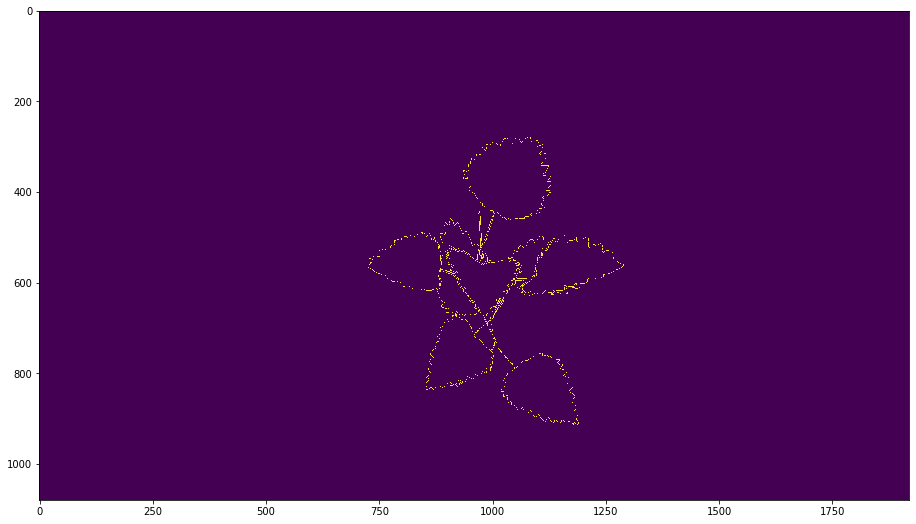

In [13]:
plt.figure(figsize=(16, 9))
plt.imshow(coodinate2image(cam2_con[0:,:,:], y=1080, x=1920))

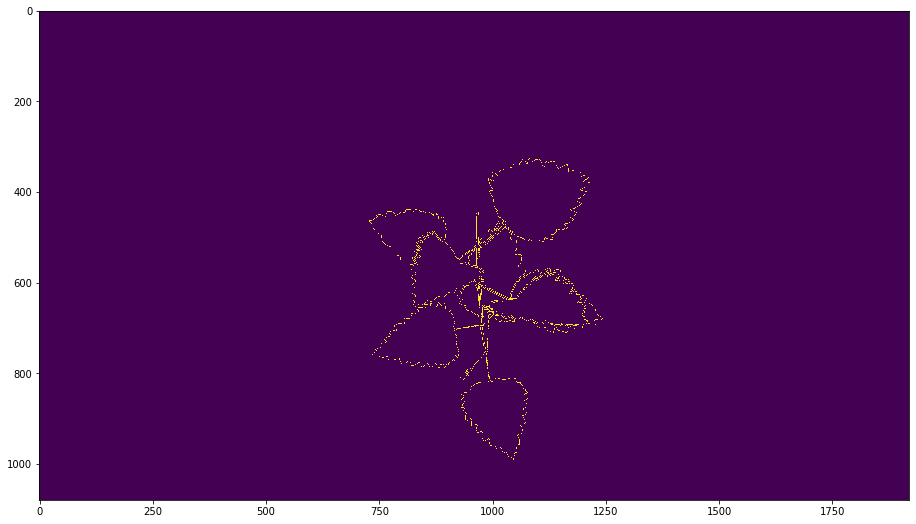

In [14]:
plt.figure(figsize=(16, 9))
plt.imshow(coodinate2image(cam1_con[0:,:,:], y=1080, x=1920))

In [15]:
def line_and_point(cam1_con, cam2_con, F):
    cam1_lines = []
    cam2_lines = []
    cam1_points = []
    cam2_points = []
    
    for color in cam1_con:
        cam2_lines.append(cv2.computeCorrespondEpilines(color[0][0], 1, F)) # ndarray(座標数,1,3)
        cam1_points.append(color[0][0])
    
    for color in cam2_con:
        cam1_lines.append(cv2.computeCorrespondEpilines(color[0][0], 2, F)) # ndarray(座標数,1,3)
        cam2_points.append(color[0][0])    
    
    return cam1_lines, cam2_points, cam2_lines, cam1_points

In [16]:
def drawline_point(img1, img2, lines, points):

    y, x, c = img1.shape
    img1 = np.copy(img1)
    img2 = np.copy(img2)
    for point, line in zip(points, lines):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -line[0][0][2]/line[0][0][1] ])
        x1,y1 = map(int, [x, -(line[0][0][2]+line[0][0][0]*x)/line[0][0][1] ])
        
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img2 = cv2.circle(img2,tuple(point[0]),10,color,-1)
    return img1, img2

In [17]:
cam1_lines, cam2_points, cam2_lines, cam1_points = line_and_point(cam1.contour_list, cam2.contour_list, F)

In [18]:
cam1_img1, cam2_img2 = drawline_point(cam1.img, cam2.img, cam1_lines, cam2_points)

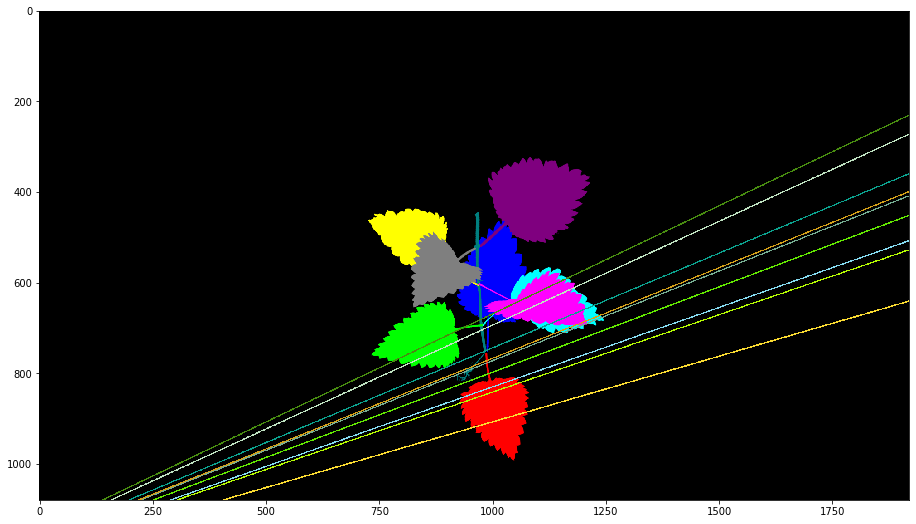

In [19]:
plt.figure(figsize=(16, 9))
plt.imshow(cam1_img1)
#plt.axis("off")

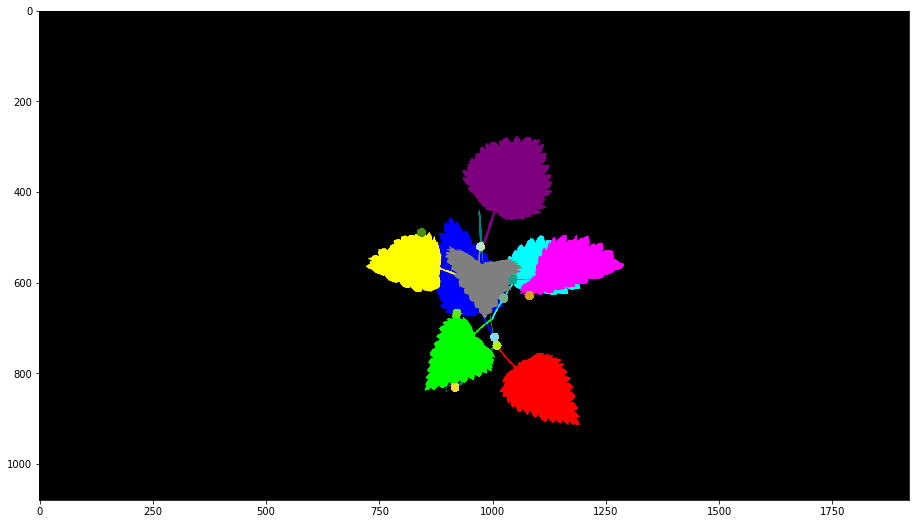

In [20]:
plt.figure(figsize=(16, 9))
plt.imshow(cam2_img2)
#plt.axis("off")

In [24]:
cam2_img1, cam1_img2 = drawline_point(cam2.img, cam1.img, cam2_lines, cam1_points)

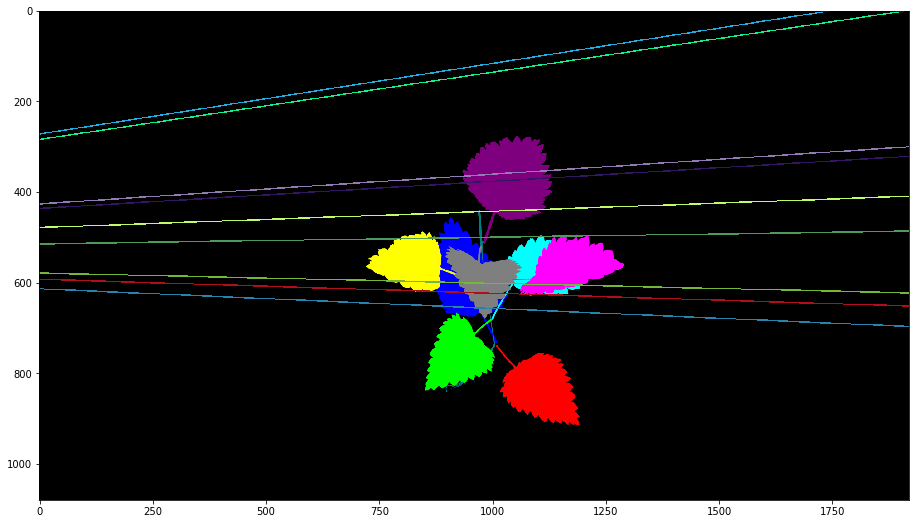

In [25]:
plt.figure(figsize=(16, 9))
plt.imshow(cam2_img1)
#plt.axis("off")

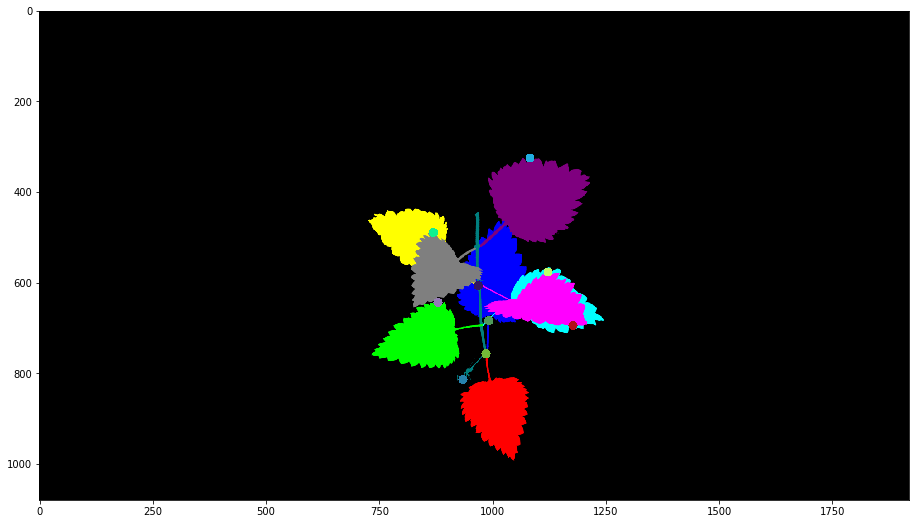

In [26]:
plt.figure(figsize=(16, 9))
plt.imshow(cam1_img2)
#plt.axis("off")

In [ ]:
img = drawlines1(cam2.img, cam2_lines)

plt.figure(figsize=(16, 9))
plt.imshow(img)
#plt.axis("off")

In [ ]:
img = drawlines1(cam1.img, cam1_lines)

plt.figure(figsize=(16, 9))
plt.imshow(img)
#plt.axis("off")

In [ ]:
cam_pairs = camera_correspondence(cam_list)

epipolar_list = []
for i in cam_pairs:
    cam1 = cam_list[i[0]]
    cam2 = cam_list[i[1]]
    cam1.img_load()
    cam2.img_load()
    cam1.contour_extraction()
    cam2.contour_extraction()
    cam1.para_load()
    cam2.para_load()
    
    F = F_mat(cam1.A, cam2.A, cam1.Rt, cam2.Rt)
    
    cam1_epi, cam2_epi = epipole(cam1.contour_list, cam2.contour_list, F)
    epi_set = [cam1_epi, cam2_epi]
    epipolar_list.append(epi_set)

In [ ]:
epipolar_list

# つながっているか
for i in range(c_list[4][0].squeeze().shape[0] - 1):
    now = c_list[4][0].squeeze()[i]
    nx = c_list[4][0].squeeze()[i+1]
    if abs(nx[0]-now[0]) > 1 or abs(nx[1]-now[1]) > 1:
        print(nx[0]-now[0],nx[1]-now[1])
        print("繋がっていない")
        break

print("繋がっている")

fst = c_list[0][0].squeeze()[0]
last = c_list[0][0].squeeze()[-1]

if abs(fst[0]-last[0]) > 1 or abs(fst[1]-last[1]) > 1:
    print("閉じてない")
else:
    print("閉じてる")

def coodinate2image(frags_list, y=1080, x=1920):
    
    
    # 座標を画像化
    frags_img = []

    for colors in frags_list:
        temp_col_list = []

        for frag in colors:
            temp_frag_img = np.zeros((y, x))

            for coordinate in frag:
                temp_frag_img[coordinate[1]][coordinate[0]] = 1

            temp_col_list.append(temp_frag_img)

        frags_img.append(temp_col_list)
        
    return frags_img